In [77]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier

from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc, RocCurveDisplay

import warnings
warnings.filterwarnings('ignore')

In [78]:
# Read CSV
df = pd.read_csv("bacteria_list_200.csv")

# Show first 5 rows
df.head()

,Name,Family,Where Found,Harmful to Humans
0,Escherichia coli,Enterobacteriaceae,Intestinal tract,Yes
1,Staphylococcus aureus,Staphylococcaceae,"Skin, nasal passages",Yes
2,Lactobacillus acidophilus,Lactobacillaceae,Human mouth & intestine,No
3,Bacillus subtilis,Bacillaceae,Soil,No
4,Clostridium botulinum,Clostridiaceae,"Soil, improperly canned foods",Yes


In [79]:
# View count of bacteria harmful to humans
df['Harmful to Humans'].value_counts()

Harmful to Humans
No      102
Yes      96
 Yes      1
Name: count, dtype: int64

In [80]:
# Replace ' Yes' with 'Yes'
df['Harmful to Humans'] = df['Harmful to Humans'].replace({' Yes': 'Yes'})

df['Harmful to Humans'].value_counts()

Harmful to Humans
No     102
Yes     97
Name: count, dtype: int64

In [81]:
# Find if there are any null values
df.isnull().sum()

Name                 0
Family               0
Where Found          0
Harmful to Humans    0
dtype: int64

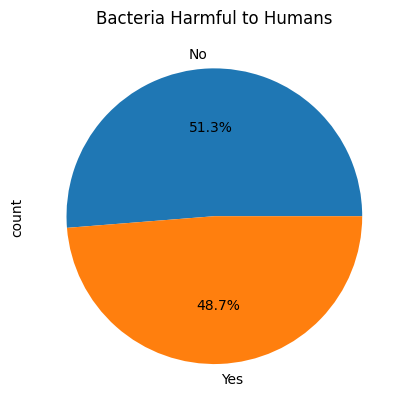

In [82]:
# Plot pie chart of bacteria harmful to humans
df['Harmful to Humans'].value_counts().plot(kind='pie', autopct='%1.1f%%')

# Add title
plt.title('Bacteria Harmful to Humans')

# Show plot
plt.show()

In [84]:
# One-hot encode all columns except 'Harmful to Humans'
ohe = OneHotEncoder()

ohe_array = ohe.fit_transform(df[['Name', 'Family', 'Where Found']]).toarray()

ohe_array

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [85]:
# Find dimensions of one-hot encoded array
ohe_array.shape

(199, 407)

In [89]:
# Label encode 'Harmful to Humans'
le = LabelEncoder()

le_array = le.fit_transform(df['Harmful to Humans'])

le_array

array([1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       1])

In [90]:
# Define function to automatically train multiple models
def model_training(models, parameters, X, y, test_size, n_iterations):
    
    # Split data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
    
    # Initialize lists to store results
    cms = []
    reports = []
    acc_scores = []
    fitted_models = []

    # Loop through models and parameters  
    for model, parameters in zip(models, parameters):
        randomized_search = RandomizedSearchCV(estimator=model, param_distributions=parameters, n_iter=n_iterations,cv=3, scoring='accuracy')
        randomized_search.fit(X_train, y_train)
        best_model = randomized_search.best_estimator_
        best_params = randomized_search.best_params_

        y_pred = best_model.predict(X_test)

        report = classification_report(y_test, y_pred)
        cm = confusion_matrix(y_test, y_pred)
        acc_score = accuracy_score(y_test, y_pred)

        cms.append(cm)
        reports.append(report)
        acc_scores.append(acc_score)
        fitted_models.append((best_model, X_test, y_test))

        print(f"Model: {best_model.__class__.__name__}")
        print("Best Parameters:", best_params)
        print("Classification Report:\n", report)
        print("Confusion Matrix:\n", cm)
        print("Accuracy Score:", acc_score)
        print("-" * 60)
    
    return cms, reports, acc_scores, fitted_models
        

In [93]:
# ML models
models = [
    RandomForestClassifier(),
    AdaBoostClassifier(),
    GradientBoostingClassifier(),
    LogisticRegression(),
    SVC(probability=True),
    XGBClassifier()
]

# ML model parameters
parameters = [
    # RandomForestClassifier
    {
        'n_estimators': [100, 200, 300],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'bootstrap': [True, False]
    },
    # AdaBoostClassifier
    {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.1, 1]
    },
    # GradientBoostingClassifier
    {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0]
    },
    # LogisticRegression
    {
        'C': [0.01, 0.1, 1, 10],
        'penalty': ['l1', 'l2', 'elasticnet'],
        'solver': ['liblinear', 'saga']
    },
    # SVC
    {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
        'gamma': ['scale', 'auto']
    },
    # XGBClassifier
    {
        'n_estimators': [100, 200, 300],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 4, 5],
        'subsample': [0.8, 0.9, 1.0],
        'colsample_bytree': [0.8, 0.9, 1.0]
    }
]

cms, reports, acc_scores, fitted_models = model_training(models, parameters, ohe_array, le_array, 0.2, 50)

Model: RandomForestClassifier
Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'bootstrap': True}
Classification Report:
               precision    recall  f1-score   support

           0       0.57      0.84      0.68        19
           1       0.75      0.43      0.55        21

    accuracy                           0.62        40
   macro avg       0.66      0.64      0.61        40
weighted avg       0.67      0.62      0.61        40

Confusion Matrix:
 [[16  3]
 [12  9]]
Accuracy Score: 0.625
------------------------------------------------------------
Model: AdaBoostClassifier
Best Parameters: {'n_estimators': 100, 'learning_rate': 1}
Classification Report:
               precision    recall  f1-score   support

           0       0.63      0.89      0.74        19
           1       0.85      0.52      0.65        21

    accuracy                           0.70        40
   macro avg       0.74      0.71      0.69    

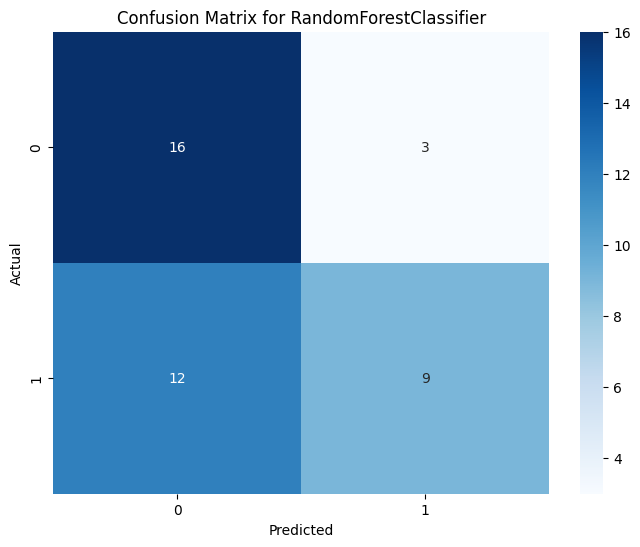

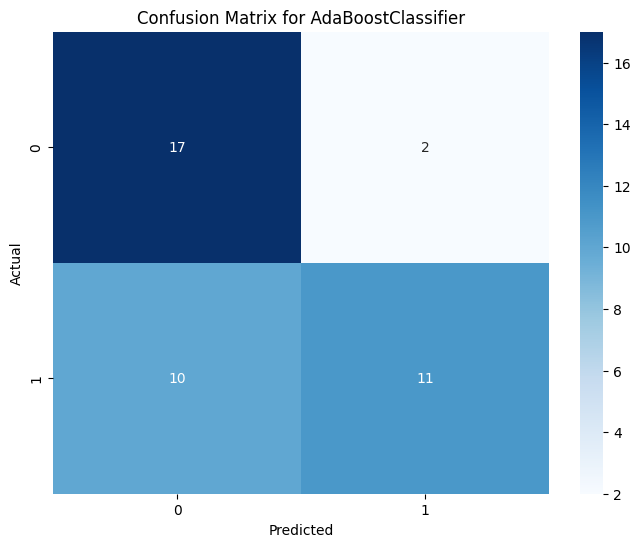

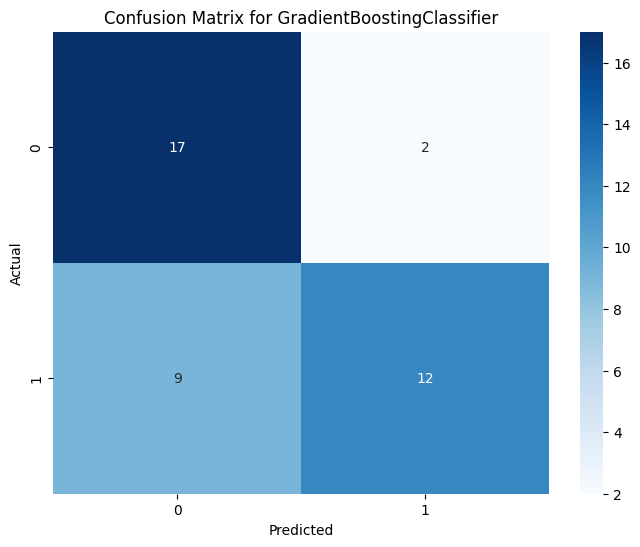

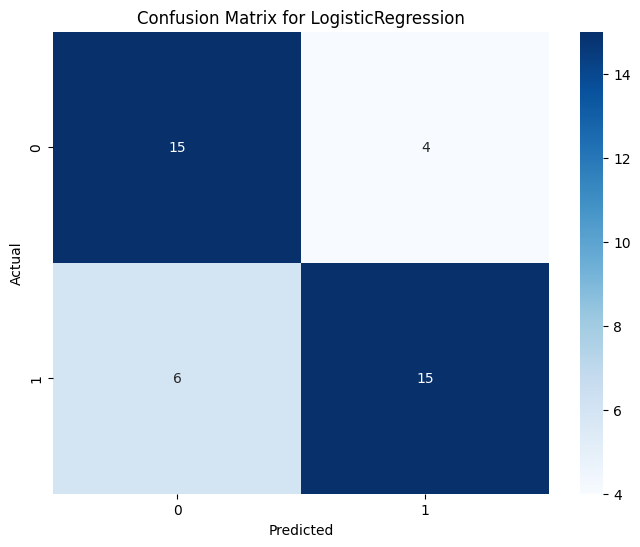

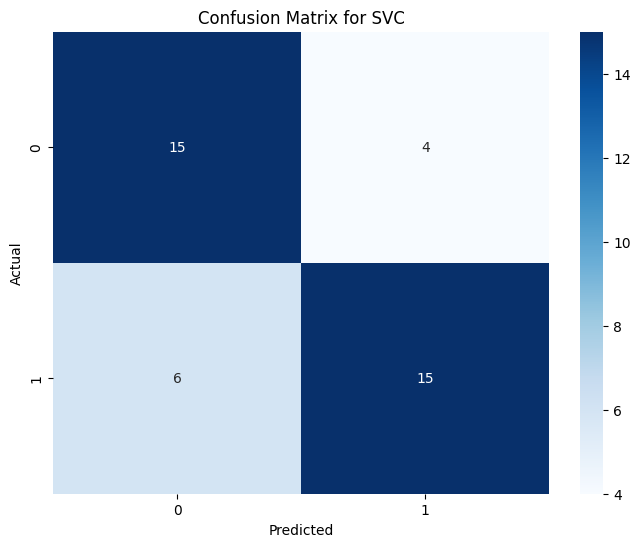

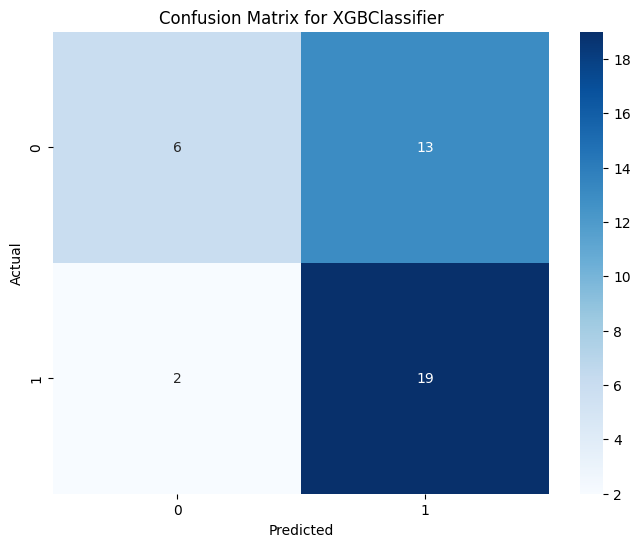

In [94]:
# Plot Confusion Matrix
def plot_confusion_matrices(cms, model_names):
    for cm, model_name in zip(cms, model_names):
        plt.figure(figsize=(8, 6))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()

# Example usage
model_names = [
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
    "LogisticRegression",
    "SVC",
    "XGBClassifier"
]

plot_confusion_matrices(cms, model_names)

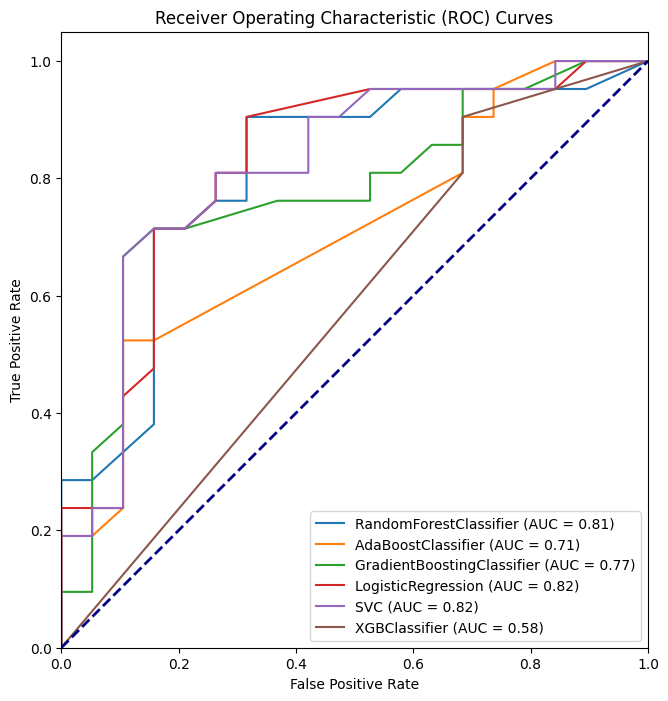

In [95]:
# Plot ROC Curves
def plot_roc_curves(fitted_models, model_names):
    plt.figure(figsize=(12, 8))
    for (model, X_test, y_test), model_name in zip(fitted_models, model_names):
        RocCurveDisplay.from_estimator(model, X_test, y_test, name=model_name, ax=plt.gca())
    
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curves')
    plt.legend(loc="lower right")
    plt.show()


model_names = [
    "RandomForestClassifier",
    "AdaBoostClassifier",
    "GradientBoostingClassifier",
    "LogisticRegression",
    "SVC",
    "XGBClassifier"
]

plot_roc_curves(fitted_models, model_names)